# Notebook Set-Up

In [6]:
import pandas as pd # import pandas - basic notebook setup

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.float_format', lambda x: '%.3f' % x) # prevents scientific notation

# Import Data

* 133,731 rows and 5 columns

In [7]:
pd.set_option('display.max_columns', None)

data = pd.read_csv(r'C:\Users\mlibonati\Desktop\Unsupervised Learning\Assignment 4\assignment-4-option-1-training.csv')

test = pd.read_csv(r'C:\Users\mlibonati\Desktop\Unsupervised Learning\Assignment 4\assignment-4-option-1-test.csv')

display(data)

pd.set_option('display.max_columns', None)

print(data.shape)
print(data.columns)

,ID,Prod,Quant,Val,Insp
0,v43,p11,1032.000,4115.000,unkn
1,v44,p11,718.000,4780.000,unkn
2,v45,p11,585.000,3810.000,unkn
3,v46,p11,904.000,7310.000,unkn
4,v42,p11,6989.000,35850.000,unkn
...,...,...,...,...,...
133726,v672,p4100,381.000,4695.000,unkn
133727,v957,p4100,100.000,1080.000,unkn
133728,v765,p4100,NaN,1020.000,unkn
133729,v10,p4100,103.000,1320.000,unkn


(133731, 5)
Index(['ID', 'Prod', 'Quant', 'Val', 'Insp'], dtype='object')


# Meta Data

Null pre-screen indicates no missing values

In [8]:
meta_df = pd.DataFrame(data = data.dtypes, columns=['Format'])
meta_df.index.rename('Field', inplace = True)

##################################
# create dataframe for NaN
##################################

na_df = (data.isnull().sum() / len(data)) * 100      
na_df = na_df.drop(na_df[na_df == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio %' :na_df})
missing_data.index.rename('Field',inplace = True)

meta_df = meta_df.join(missing_data).fillna(0)

##################################
# merge unique values for each field onto meta data df
##################################

unique_df = pd.DataFrame(data=[],columns=['Field','Unique_Values','Number of Unique Values'])

for col in data.columns:
    unique_df = unique_df.append(pd.DataFrame(data=[[col,
                                                     data[col].unique(),
                                                     len(data[col].value_counts())]],
                                              columns = ['Field','Unique_Values','Number of Unique Values']))

unique_df.set_index('Field',inplace = True)
    
meta_df = meta_df.join(unique_df)    
    
##################################
# merge unique values for each field onto meta data df
##################################

descriptions = pd.DataFrame(data = [['ID'    , 'sales representative identification (not to be used in the anomaly detection model)'                             ],
                                    ['Prod'  , 'Product Number'                                                                                                  ],
                                    ['Quant' , 'quantity of the product that the sales representative claims to have sold'                                       ],
                                    ['Val'   , 'the value of the total sale that the sales representative claims to have sold (units unknown, most likely euros)'],
                                    ['Insp'  , 'Inspection Result (Target)'                                                                                      ]],
                            columns = ['Field','Description'])
    
descriptions.set_index('Field',inplace = True)
    
meta_df = meta_df.join(descriptions).sort_values(by = ['Format','Missing Ratio %'])

meta_df = meta_df.reset_index()

pd.set_option('display.max_colwidth', 150)

meta_df

,Field,Format,Missing Ratio %,Unique_Values,Number of Unique Values,Description
0,Val,float64,0.386,"[4115.0, 4780.0, 3810.0, 7310.0, 35850.0, 133925.0, 145225.0, 214235.0, 79515.0, 12795.0, 99800.0, 16580.0, 24800.0, 7600.0, 82985.0, 167300.0, 15...",11832,"the value of the total sale that the sales representative claims to have sold (units unknown, most likely euros)"
1,Quant,float64,3.349,"[1032.0, 718.0, 585.0, 904.0, 6989.0, 21135.0, 22167.0, 35335.0, 12206.0, 1908.0, 15255.0, 3083.0, 4908.0, 1312.0, 15880.0, 31987.0, 2771.0, 16755...",11474,quantity of the product that the sales representative claims to have sold
2,ID,object,0.000,"[v43, v44, v45, v46, v42, v47, v48, v49, v50, v51, v52, v57, v58, v59, v60, v35, v68, v62, v56, v33, v53, v70, v71, v72, v69, v73, v74, v75, v67, ...",5098,sales representative identification (not to be used in the anomaly detection model)
3,Prod,object,0.000,"[p11, p12, p14, p20, p26, p30, p31, p32, p33, p46, p49, p50, p51, p59, p60, p63, p65, p71, p73, p87, p92, p99, p108, p109, p112, p122, p152, p154,...",798,Product Number
4,Insp,object,0.000,[unkn],1,Inspection Result (Target)


# Pre-processing

##### Specify Lists and Datasets

In [9]:
string_cols = meta_df[(meta_df['Format'] == 'object') & (meta_df['Field'] != 'class')]['Field'].values.tolist() 
float_cols  = meta_df[meta_df['Format'] == 'float64']['Field'].values.tolist()
int_cols    = meta_df[meta_df['Format'] == 'int64']['Field'].values.tolist()
print(f'String Cols: {string_cols}\nFloat Cols: {float_cols}\nint_cols: {int_cols}')

String Cols: ['ID', 'Prod', 'Insp']
Float Cols: ['Val', 'Quant']
int_cols: []


##### Analyze Test Quantity/ Volume Scatter Plot

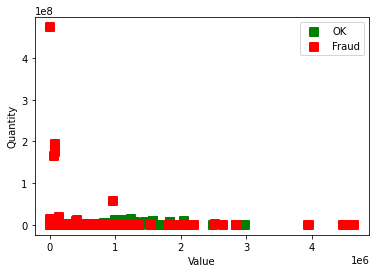

In [10]:
# Scatter plot of "Val" and "Quant" on Test Data
import matplotlib.pyplot as plt

ok      = test[test['Insp'] == 'ok']
fraud   = test[test['Insp'] == 'fraud']

plt.scatter(ok['Val'], ok['Quant'], c ="green",
            linewidths = 2,
            marker ="s",
            edgecolor ="green",
            s = 50, label = 'OK')

plt.scatter(fraud['Val'], fraud['Quant'], c ="red",
            linewidths = 2,
            marker ="s",
            edgecolor ="red",
            s = 50, label = 'Fraud')

plt.xlabel("Value")
plt.ylabel("Quantity")
plt.legend()
plt.show()

# Process Data

In [57]:
# Remove NaN's from dataset
model_data_drop_na = data.dropna().reset_index().drop(columns = ['index']) 
model_test_drop_na = test.dropna().reset_index().drop(columns = ['index']) 

# Impute NaN's as Avg

# Impute NaN's as -1  

# Isolation Forest

Field,ID,Prod,Quant,Val,Insp,scores,anomaly_iso
0,v43,p11,1032.000,4115.000,unkn,0.116,1
1,v44,p11,718.000,4780.000,unkn,0.118,1
2,v45,p11,585.000,3810.000,unkn,0.129,1
3,v46,p11,904.000,7310.000,unkn,0.108,1
4,v42,p11,6989.000,35850.000,unkn,0.006,1
5,v47,p11,21135.000,133925.000,unkn,-0.190,-1
6,v48,p11,22167.000,145225.000,unkn,-0.191,-1
7,v49,p11,35335.000,214235.000,unkn,-0.237,-1
8,v49,p11,12206.000,79515.000,unkn,-0.105,-1
9,v50,p11,1908.000,12795.000,unkn,0.095,1


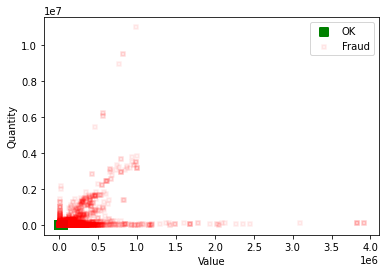

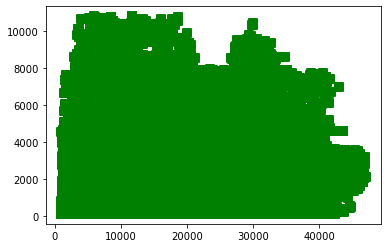

Field,ID,Prod,Quant,Val,Insp,scores,anomaly_iso
0,v43,p11,1032.000,4115.000,unkn,0.116,1
1,v44,p11,718.000,4780.000,unkn,0.118,1
2,v45,p11,585.000,3810.000,unkn,0.129,1
3,v46,p11,904.000,7310.000,unkn,0.108,1
4,v42,p11,6989.000,35850.000,unkn,0.006,1
...,...,...,...,...,...,...,...
129086,v1040,p4100,101.000,1035.000,unkn,0.166,1
129087,v672,p4100,381.000,4695.000,unkn,0.143,1
129088,v957,p4100,100.000,1080.000,unkn,0.171,1
129089,v10,p4100,103.000,1320.000,unkn,0.173,1


In [49]:
# Isolation Forest: Based on the Decision Tree algorithm. 
# It isolates the outliers by randomly selecting a feature from the given set of features 
# and then randomly selecting a split value between the max and min values of that feature.
# This is used here to simulate "fruad" --> train data is unlabeled.

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# Create Isolation Forest Model


model=IsolationForest(n_estimators=50,          # num base estimators or trees in the ensemble; parameter is optional, default value = 100
                      
                      max_samples='auto',       # num samples drawn to train each base estimator. If max_samples > num samples provided, all samples will be used for all trees. default = 'auto' = max_samples=min(256, n_samples)
                      
                      contamination=float(0.1), # This param is quite sensitive; refers to the expected proportion of outliers in the data. used when fitting to define the threshold on the scores of the samples. 
                                                # The default value is 'auto'. If ‘auto’, the threshold value will be determined as in the original paper of Isolation Forest.
                      
                      max_features=1.0)         # All the base estimators are not trained with all the features available in the dataset. 
                                                # It is the number of features to draw from the total features to train each base estimator or tree.The default value of max features is one.
model.fit(model_data_drop_na[['Val','Quant']])

model_data_drop_na['scores'] = model.decision_function(model_data_drop_na[['Val','Quant']])
model_data_drop_na['anomaly_iso']= model.predict(model_data_drop_na[['Val','Quant']])
display(model_data_drop_na.head(10))

# plot isolation forest model outcome
ok      = model_data_drop_na[model_data_drop_na['anomaly_iso'] == 1]
fraud   = model_data_drop_na[model_data_drop_na['anomaly_iso'] == -1]

plt.scatter(ok['Val'], ok['Quant'], c ="green",
            linewidths = 2,
            marker ="s",
            edgecolor ="green",
            s = 50, label = 'OK')

plt.scatter(fraud['Val'], fraud['Quant'], c ="red",
            linewidths = 2,
            marker ="s",
            edgecolor ="red",
            alpha = .05,
            s = 10, label = 'Fraud')

plt.xlabel("Value")
plt.ylabel("Quantity")
plt.legend()
plt.show()

plt.scatter(ok['Val'], ok['Quant'], c ="green",
            linewidths = 2,
            marker ="s",
            edgecolor ="green",
            s = 50, label = 'OK')
plt.show()

display(model_data_drop_na)

#################
## Evaluating the Model

# # create an outliers counter to detect the isolation forests ability to identify outliers
# outliers_counter = len(model_data[(model_data['Val'] > 500000) | (model_data['Quant'] > 150000)]) # define thi
# print(outliers_counter)
# print("Accuracy percentage:", len(model_data[model_data['anomaly'] == 1])/outliers_counter)

#### DBSCAN

https://www.reneshbedre.com/blog/dbscan-python.html <br>
Requires 2 Parameters:
1. E = domain expertise of nearest neighbors; Set by Knee of the curve 
2. minPts = 2 & num dimensions <br>
<br>
<b>DBSCAN Shortcommings:</b>
* Computationally expensive/ Time Consuming compared to K-means
* sensitive to input parameters
* depends on single value of E for all clusters, therefor, clusters with variable densities may not be correctly identifiable

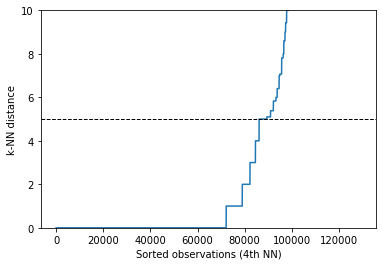

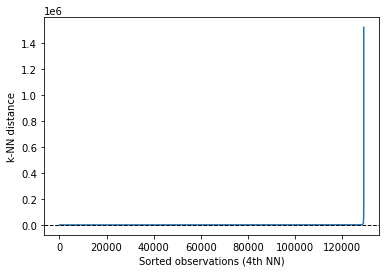

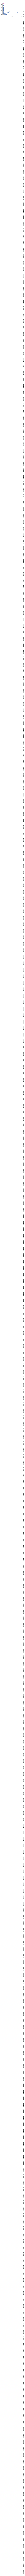

,ID,Prod,Quant,Val,Insp,scores,anomaly_iso,DBSCAN_Cluster,anomaly_dbscan
0,v43,p11,1032.000,4115.000,unkn,0.116,1,-1,0
1,v44,p11,718.000,4780.000,unkn,0.118,1,-1,0
2,v45,p11,585.000,3810.000,unkn,0.129,1,-1,0
3,v46,p11,904.000,7310.000,unkn,0.108,1,-1,0
4,v42,p11,6989.000,35850.000,unkn,0.006,1,-1,0
...,...,...,...,...,...,...,...,...,...
129086,v1040,p4100,101.000,1035.000,unkn,0.166,1,0,1
129087,v672,p4100,381.000,4695.000,unkn,0.143,1,-1,0
129088,v957,p4100,100.000,1080.000,unkn,0.171,1,0,1
129089,v10,p4100,103.000,1320.000,unkn,0.173,1,0,1


In [50]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
# n_neighbors = 5 as kneighbors function returns distance of point to itself (i.e. first column will be zeros) 
nbrs = NearestNeighbors(n_neighbors=5).fit(model_data_drop_na[['Quant','Val']])
# Find the k-neighbors of a point
neigh_dist, neigh_ind = nbrs.kneighbors(model_data_drop_na[['Quant','Val']])
# sort the neighbor distances (lengths to points) in ascending order
# axis = 0 represents sort along first axis i.e. sort along row
sort_neigh_dist = np.sort(neigh_dist, axis=0)

import matplotlib.pyplot as plt
k_dist = sort_neigh_dist[:, 1]
plt.plot(k_dist)
plt.axhline(y=5, linewidth=1, linestyle='dashed', color='k')
plt.ylabel("k-NN distance")
plt.xlabel("Sorted observations (5th NN)")
plt.ylim(0, 10)
plt.show()

import matplotlib.pyplot as plt
k_dist = sort_neigh_dist[:, 1]
plt.plot(k_dist)
plt.axhline(y=5, linewidth=1, linestyle='dashed', color='k')
plt.ylabel("k-NN distance")
plt.xlabel("Sorted observations (5th NN)")
plt.show()

from sklearn.cluster import DBSCAN
clusters = DBSCAN(eps=5, min_samples=4).fit(model_data_drop_na[['Quant','Val']])
# get cluster labels
clusters.labels_

# check unique clusters
set(clusters.labels_)

# Get each Clusters Size
from collections import Counter
Counter(clusters.labels_)

# Visualization of DBScan Ploting

import seaborn as sns
import matplotlib.pyplot as plt
p = sns.scatterplot(data=model_data_drop_na[['Quant','Val']], x="Quant", y="Val", hue=clusters.labels_, legend="full", palette="deep")
sns.move_legend(p, "upper right", bbox_to_anchor=(1.17, 1.2), title='Clusters')
plt.show()

# model dataset
model_data_drop_na = model_data_drop_na.join(pd.DataFrame(data = clusters.labels_, columns = ['DBSCAN_Cluster']))
model_data_drop_na['anomaly_dbscan'] = np.where(model_data_drop_na['DBSCAN_Cluster'] == -1, 0, 1)
model_data_drop_na

#### Build Cart Decision Tree

|--- feature_0 <= 6846.00
|   |--- feature_1 <= 41400.00
|   |   |--- feature_1 <= 36397.50
|   |   |   |--- class: 1
|   |   |--- feature_1 >  36397.50
|   |   |   |--- class: 1
|   |--- feature_1 >  41400.00
|   |   |--- feature_1 <= 52930.00
|   |   |   |--- class: -1
|   |   |--- feature_1 >  52930.00
|   |   |   |--- class: -1
|--- feature_0 >  6846.00
|   |--- feature_0 <= 11767.00
|   |   |--- feature_1 <= 23550.00
|   |   |   |--- class: 1
|   |   |--- feature_1 >  23550.00
|   |   |   |--- class: -1
|   |--- feature_0 >  11767.00
|   |   |--- feature_0 <= 13844.50
|   |   |   |--- class: -1
|   |   |--- feature_0 >  13844.50
|   |   |   |--- class: -1

|--- feature_0 <= 6846.00
|   |--- feature_1 <= 41400.00
|   |   |--- feature_1 <= 36397.50
|   |   |   |--- class: 1
|   |   |--- feature_1 >  36397.50
|   |   |   |--- class: 1
|   |--- feature_1 >  41400.00
|   |   |--- feature_1 <= 52930.00
|   |   |   |--- class: -1
|   |   |--- feature_1 >  52930.00
|   |   |   |--- class:

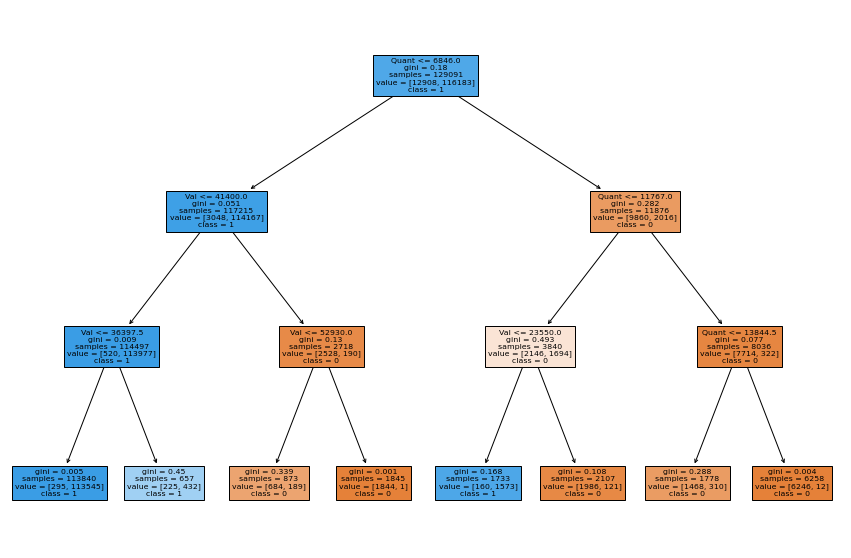

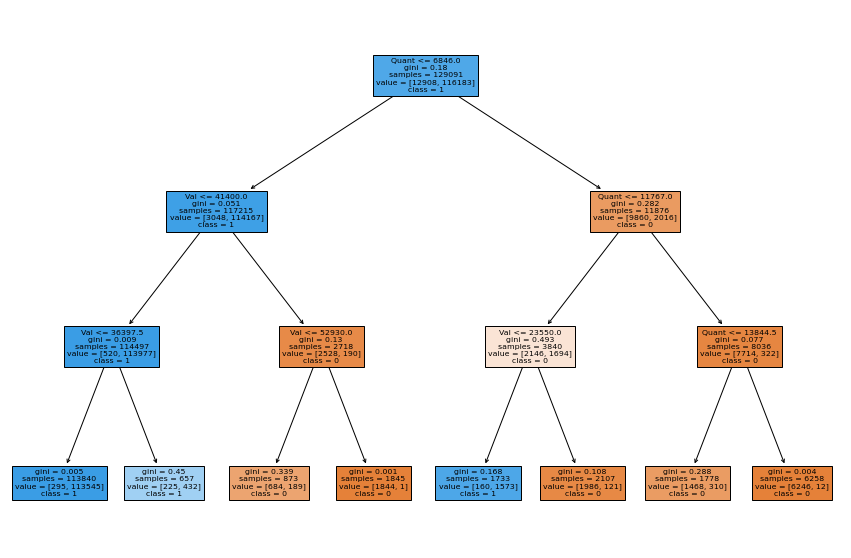

In [51]:
%matplotlib inline
#%matplotlib qt
# CART training algorithm
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

###################
## Isolation Forest
###################

# import data
X = model_data_drop_na[['Quant','Val']].to_numpy()
y = model_data_drop_na[['anomaly_iso']].to_numpy()

# # calibrate model
tree_clf_iso_drop_na = DecisionTreeClassifier(max_depth=3)
tree_clf_iso_drop_na.fit(X,y)

# print tree paths
text_representation = tree.export_text(tree_clf)
print(text_representation)

# plot tree
with open("decistion_tree.log", "w") as fout:
    fout.write(text_representation)
    
fig = plt.figure(figsize=(15,10))
_ = tree.plot_tree(tree_clf, 
                   feature_names=['Quant','Val'],  
                   class_names=['0','1'],
                   filled=True)

###################
## DBSCAN
###################
# import data
X = model_data_drop_na[['Quant','Val']].to_numpy()
y = model_data_drop_na[['anomaly_dbscan']].to_numpy()

# # calibrate model
tree_clf_dbscan_drop_na = DecisionTreeClassifier(max_depth=3)
tree_clf_dbscan_drop_na.fit(X,y)

# print tree paths
text_representation = tree.export_text(tree_clf)
print(text_representation)

# plot tree
with open("decistion_tree.log", "w") as fout:
    fout.write(text_representation)
    
fig = plt.figure(figsize=(15,10))
_ = tree.plot_tree(tree_clf, 
                   feature_names=['Quant','Val'],  
                   class_names=['0','1'],
                   filled=True)

############################
## ISOLATION FOREST + DBSCAN
############################

#### Build Models

In [58]:
model_test_drop_na['Insp'] = model_test_drop_na['Insp'].map({'ok':0,'fraud':1})

# Cart Model - Isolation Forest
predictions = pd.DataFrame(tree_clf_iso_drop_na.predict(model_test_drop_na[['Quant','Val']]), columns = ['y_pred_iso_drop_na'])
model_test_drop_na = model_test_drop_na.join(predictions)
model_test_drop_na['y_pred_iso_drop_na'] = model_test_drop_na['y_pred_iso_drop_na'].map({-1:0,1:1})

# Cart Model - DBSCAN
predictions = pd.DataFrame(tree_clf_dbscan_drop_na.predict(model_test_drop_na[['Quant','Val']]), columns = ['y_pred_dbscan_drop_na'])
#display(predictions)
model_test_drop_na = model_test_drop_na.join(predictions)
#model_test_drop_na['y_pred_dbscan_drop_na'] = model_test_drop_na['y_pred_dbscan_drop_na'].map({-1:0,1:1})

# Cart Model - Isolation Forest + DBSCAN


model_test_drop_na

,ID,Prod,Quant,Val,Insp,y_pred_iso_drop_na,y_pred_dbscan_drop_na
0,v42,p11,51097.000,310780.000,0,0,0
1,v45,p11,260.000,1925.000,0,1,0
2,v42,p11,51282.000,278770.000,0,0,0
3,v50,p11,46903.000,281485.000,0,0,0
4,v46,p12,475.000,2600.000,0,1,0
...,...,...,...,...,...,...,...
15541,v3854,p4096,1567.000,21180.000,0,1,0
15542,v3179,p4096,907.000,17350.000,0,1,0
15543,v4561,p4096,1212.000,31970.000,0,1,0
15544,v3179,p4096,650.000,18290.000,0,1,0


#### Model Validation

In [62]:
from sklearn.metrics import confusion_matrix 

score_df = pd.DataFrame()

cols = ['y_pred_iso_drop_na','y_pred_dbscan_drop_na']

for col in cols:
    conf_matrix = confusion_matrix(model_test_drop_na[['Insp']], model_test_drop_na[[col]])

    print(f'Confusion Matrix:\n {conf_matrix}')

    score_df = score_df.append(pd.DataFrame([[col,conf_matrix[0][0],conf_matrix[0][1],conf_matrix[1][0],conf_matrix[1][1]]]))
    
score_df.columns = ['Model','TP','FP','FN','TN']

score_df['Precision']     = score_df['TP'] / (score_df['TP']+score_df['FP'])
score_df['Recall']        = score_df['TP'] / (score_df['TP']+score_df['TN'])
score_df['Type I Error']  = score_df['FP']
score_df['Type II Error'] = score_df['TN']
score_df['F1 Score']      = 2 * ((score_df['Precision'] * score_df['Recall'])/(score_df['Precision'] + score_df['Recall']))

display(score_df)

Confusion Matrix:
 [[5134 9213]
 [ 489  710]]
Confusion Matrix:
 [[9365 4982]
 [1062  137]]


,Model,TP,FP,FN,TN,Precision,Recall,Type I Error,Type II Error,F1 Score
0,y_pred_iso_drop_na,5134,9213,489,710,0.358,0.879,9213,710,0.509
0,y_pred_dbscan_drop_na,9365,4982,1062,137,0.653,0.986,4982,137,0.785
